In [19]:
from datetime import datetime
import datetime as dt
import time
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
import IPython as ip
import  os as os

In [2]:
sg = Subgrounds()
apiKey = input('API Key, please')

In [20]:
#for when we save the files
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
file = file+'/data'
if not os.path.exists(file):
    os.makedirs(file)

*******************************************************************
*******************************************************************
LET'S LOOK AT SILO BORROWS FIRST

In [21]:
#SILO subgraph: https://gateway.thegraph.com/api/[api-key]/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB
silo = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB')

##this captures the list of people who borrowed XAI against gOHM
borrows = silo.Query.borrows(
    orderBy='timestamp',
    orderDirection='desc',
    first=1000,
    #skip = skipValue,
    where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' }

)

borrowsDb = sg.query_df([
    borrows.id
    ,borrows.hash
    ,borrows.logIndex
    ,borrows.blockNumber
    ,borrows.timestamp
    ,borrows.account
    ,borrows.market
    ,borrows.market.rates
    ,borrows.asset
    ,borrows.amount
    ,borrows.amountUSD 
])
borrowsDb.head(100)

#this, in turn, pulls repayment events
repays = silo.Query.repays(
    orderBy='timestamp',
    orderDirection='desc',
    first=1000,
    #skip = skipValue,
    where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' }

)

repaysDb = sg.query_df([
    repays.id
    ,repays.hash
    ,repays.logIndex
    ,repays.blockNumber
    ,repays.timestamp
    ,repays.account
    ,repays.market
    ,repays.market.rates
    ,repays.asset
    ,repays.amount
    ,repays.amountUSD
    ,repays.position
])
repaysDb.head(100)

In [22]:
oldBorrowsDb = pd.DataFrame()
siloFileName = file+'/siloFinance_borrows.csv'
try:
    oldBorrowsDb = pd.read_csv (siloFileName)
except:
    oldBorrowsDb = pd.DataFrame()
oldBorrowsDb.head(100)

""


In [23]:
maxSiloBorrowTimestamp = 0
try:
    maxSiloBorrowTimestamp = (max(0,oldBorrowsDb['transaction_timestamp'].max()))-5
except:
        maxSiloBorrowTimestamp = 0
maxSiloBorrowTimestamp = int(maxSiloBorrowTimestamp)
maxSiloBorrowTimestamp

0

In [24]:
##this captures the ENTIRE list of people who borrowed XAI against gOHM
borrowTicker = 0
borrowslist = pd.DataFrame()
borrowsDb = pd.DataFrame()
borrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (borrowTicker)*(1000)
    borrows = silo.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0'
                ,'timestamp_gte': maxSiloBorrowTimestamp
                } #gOHM market

    )

    borrowslist = sg.query_df([
        borrows.id
        ,borrows.hash
        ,borrows.blockNumber
        ,borrows.timestamp
        ,borrows.account.id
        ,borrows.market.id
        ,borrows.market.protocol.id
        ,borrows.market.rates.rate
        ,borrows.market.rates.duration
        ,borrows.market.rates.side
        ,borrows.market.rates.type
        ,borrows.market.rates.token.id
        ,borrows.asset.name
        ,borrows.asset.symbol
        ,borrows.asset.decimals
        ,borrows.asset.lastPriceUSD
        ,borrows.amount
        ,borrows.amountUSD
    ])

    #borrowslist.sort_values(by=['borrows_timestamp'])

    borrowsDb=pd.concat([borrowsDb, borrowslist])
    recordTimestamp1 = borrowsDb.iat[borrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    borrowsDbLength = len(borrowsDb)
    borrowListLength = len(borrowslist)
    recordID = borrowsDb.iat[borrowTicker,0]
    borrow = borrowsDb.iat[borrowTicker,1]
    print("iterations: ", borrowTicker, "Lines skipped: ",skipValue, "records collected: ", borrowListLength, " - latest recordID: ",borrow, " ", recordID , " - borrows DB length: ", borrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", borrowTicker, "records collected: ", borrowListLength, " - userdb length: ", borrowsDbLength)
    borrowTicker = borrowTicker+1

    if daysAgo>daysLimit: exit =True
    if borrowListLength<1000: exit =True

borrowsDb.columns = borrowsDb.columns.str.replace("borrows", "transaction")
borrowsDb['event']='borrow'
borrowsDb.drop_duplicates
print("Done. Total Records collected: ", borrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  150  - latest recordID:  0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c737cda5a8e695f13fdd9   0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c737cda5a8e695f13fdd9-277  - borrows DB length:  150  - latest record from:  2023-02-16 15:31:47 1 days ago
Done. Total Records collected:  150


In [25]:
borrowsDb.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event
0,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1679.325377,600000000000000000,995.052978,borrow
1,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1679.325377,600000000000000000,995.052978,borrow
2,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,None,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Wrapped Ether,WETH,18,1679.325377,600000000000000000,995.052978,borrow
3,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1679.325377,600000000000000000,995.052978,borrow
4,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,0xd9329978828295f4f091eaa77a6d8c388c5616bbe92c...,16644592,1676590307,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.117764,None,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1679.325377,600000000000000000,995.052978,borrow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x4fa0cb2fdde04b90f07602351b260aa5202562c7b701...,0x4fa0cb2fdde04b90f07602351b260aa5202562c7b701...,16574830,1675747799,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.977887,None,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.987225,6030000000000000000000,6015.596587,borrow
96,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.987225,25000000000000000000000,24937.155253,borrow
97,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.987225,25000000000000000000000,24937.155253,borrow
98,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,None,BORRO

In [26]:
#I swear I will figure out synthetic fields, but until then...
borrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From borrowsDb "
                      "order by transaction_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.117764,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,16634870,1676472911,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.977887,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.987225,3.000000e+21,3023.153053,borrow,2023-02-15 14:55:11
96,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1679.325377,1.920000e+18,2885.217480,borrow,2023-02-14 11:50:59
97,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1679.325377,1.920000e+18,2885.217480,borrow,2023-02-14 11:50:59
98,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77

In [27]:
borrowsDbTimed = pd.concat([oldBorrowsDb,borrowsDbTimed]).drop_duplicates().reset_index(drop=True)
borrowsDbTimed.drop_duplicates()
borrowsDbTimed = db.query("select "
               "    * "
               "From borrowsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.211199,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.117764,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,0.987225,1.860000e+23,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,0xfa292276fc71f90e29ca90a7b8a2be9a4094f459fb99...,16634870,1676472911,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.977887,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,0.987225,3.000000e+21,3023.153053,borrow,2023-02-15 14:55:11
96,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Wrapped Ether,WETH,18,1679.325377,1.920000e+18,2885.217480,borrow,2023-02-14 11:50:59
97,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77d,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.983536,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,1679.325377,1.920000e+18,2885.217480,borrow,2023-02-14 11:50:59
98,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,0x39c11cb01e34d9f8ca55a8820482eaf8a217033cdb6f...,16626801,1676375459,0x16ff8ad104fa6195260a6d4a3f311c5f120df77

In [28]:
siloBorrowEventsDbTimedClean = db.query("select "
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", (transaction_amount::hugeint*1e-17) transactionReadableAmount "
                            ", transaction_amountUSD "
                            ", dateTime "
                            ", date_trunc('day', dateTime) calDate "
               "From borrowsDbTimed "
                         "group by"
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", transaction_amountUSD "
                            ", dateTime "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
siloBorrowEventsDbTimedClean.head(100)

,transaction_id,event,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_asset_name,transaction_asset_symbol,transaction_amount,transactionReadableAmount,transaction_amountUSD,dateTime,calDate
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,borrow,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,1.860000e+23,1.860000e+06,185996.147731,2023-02-09 06:23:59,2023-02-09
1,0x3b0f26e10c63a71c916e8a68bd1889d9bab38aeb62d7...,borrow,0x3b0f26e10c63a71c916e8a68bd1889d9bab38aeb62d7...,16641746,1676556011,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,1.000000e+23,1.000000e+06,100012.487283,2023-02-16 14:00:11,2023-02-16
2,0x3dba2dd3c913b399164efd71db73121c9c94c0096139...,borrow,0x3dba2dd3c913b399164efd71db73121c9c94c0096139...,16622907,1676328371,0x46535cbc3fa574c32ea392d4f89c518290597072,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,Governance OHM,gOHM,2.640000e+19,2.640000e+02,71910.521424,2023-02-13 22:46:11,2023-02-13
3,0x072c04ee8776ea91e8c1003bad2d401e3ac90d0ab2fc...,borrow,0x072c04ee8776ea91e8c1003bad2d401e3ac90d0ab2fc...,16579820,1675808183,0x0493bcca897a2248ae3cd4c66aea90dbfc7e13c6,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,3.000000e+22,3.000000e+05,29884.417447,2023-02-07 22:16:23,2023-02-07
4,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,borrow,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,2.500000e+22,2.500000e+05,24937.155253,2023-02-07 00:02:35,2023-02-07
5,0x38ce8e39e188c85ba03a340cdde95c2e1d56b54161e6...,borrow,0x38ce8e39e188c85ba03a340cdde95c2e1d56b54161e6...,16579819,1675808171,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,2.000000e+22,2.000000e+05,19922.944964,2023-02-07 22:16:11,2023-02-07
6,0x2485acd5a3853dc50921a27ea5bf8227871425cca3e4...,borrow,0x2485acd5a3853dc50921a27ea5bf8227871425cca3e4...,16171818,1670886647,0x1ba67f30e25fc43863b50047d7fd4bd63b9c59ec,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,1.190000e+22,1.190000e+05,11928.568949,2022-12-12 23:10:47,2022-12-12
7,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,borrow,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,16505284,1674908519,0x42daeb9ca091e3933c8ee93c029701b926b1f336,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,1.000000e+22,1.000000e+05,10040.961438,2023-01-28 12:21:59,2023-01-28
8,0xbfc6df3a770233f4e0fbd6fe0cf8f6fa02f1432c570f...,borrow,0xbfc6df3a770233f4e0fbd6fe0cf8f6fa02f1432c570f...,16173505,1670906999,0x339fd7c17ce670e7821f2f2ee94ddd49771483da,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,8.000000e+21,8.000000e+04,8040.631376,2022-12-13 04:49:59,2022-12-13
9,0x045f19530c6f8c0b6eca525f3921e207938e841b3670...,borrow,0x045f19530c6f8c0b6eca525f3921e207938e841b3670...,16580114,1675811711,0xb86cd2efc1f461beee8deec2c3f053ccb2781ef9,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,7.000000e+21,7.000000e+04,6976.053341,2023-02-07 23:15:11,2023-02-07


Why the heck do I see several interest rates for the same txn?

In [29]:
path =file+'/siloFinance_borrows.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False)

path =file+'/siloFinance_borrows_piped.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(siloBorrowEventsDbTimedClean),' records')

/Users/ianbrillembourg/Dropbox/Documents/Edgecaser LLC/Projects/Olympus/Econohmetrics/gohmAsStablecoinCollateral/data/siloFinance_borrows_piped.csv file saved, 25  records


In [30]:
totalBorrowed = sum(siloBorrowEventsDbTimedClean['transactionReadableAmount'])
print('There has been a total of',round(totalBorrowed,2),  'OHM borrowed cumulatively to date')

There has been a total of 4286670.04 OHM borrowed cumulatively to date


In [31]:
totalBorrowedUSD = sum(siloBorrowEventsDbTimedClean['transaction_amountUSD'])
print('That\'s $',round(totalBorrowedUSD,2),  'USD at last price')

That's $ 504632.15 USD at last price


[Text(0.5, 1.0, 'OHM borrowed per day'), Text(0.5, 0, 'Date'), Text(0, 0.5, 'OHM')]


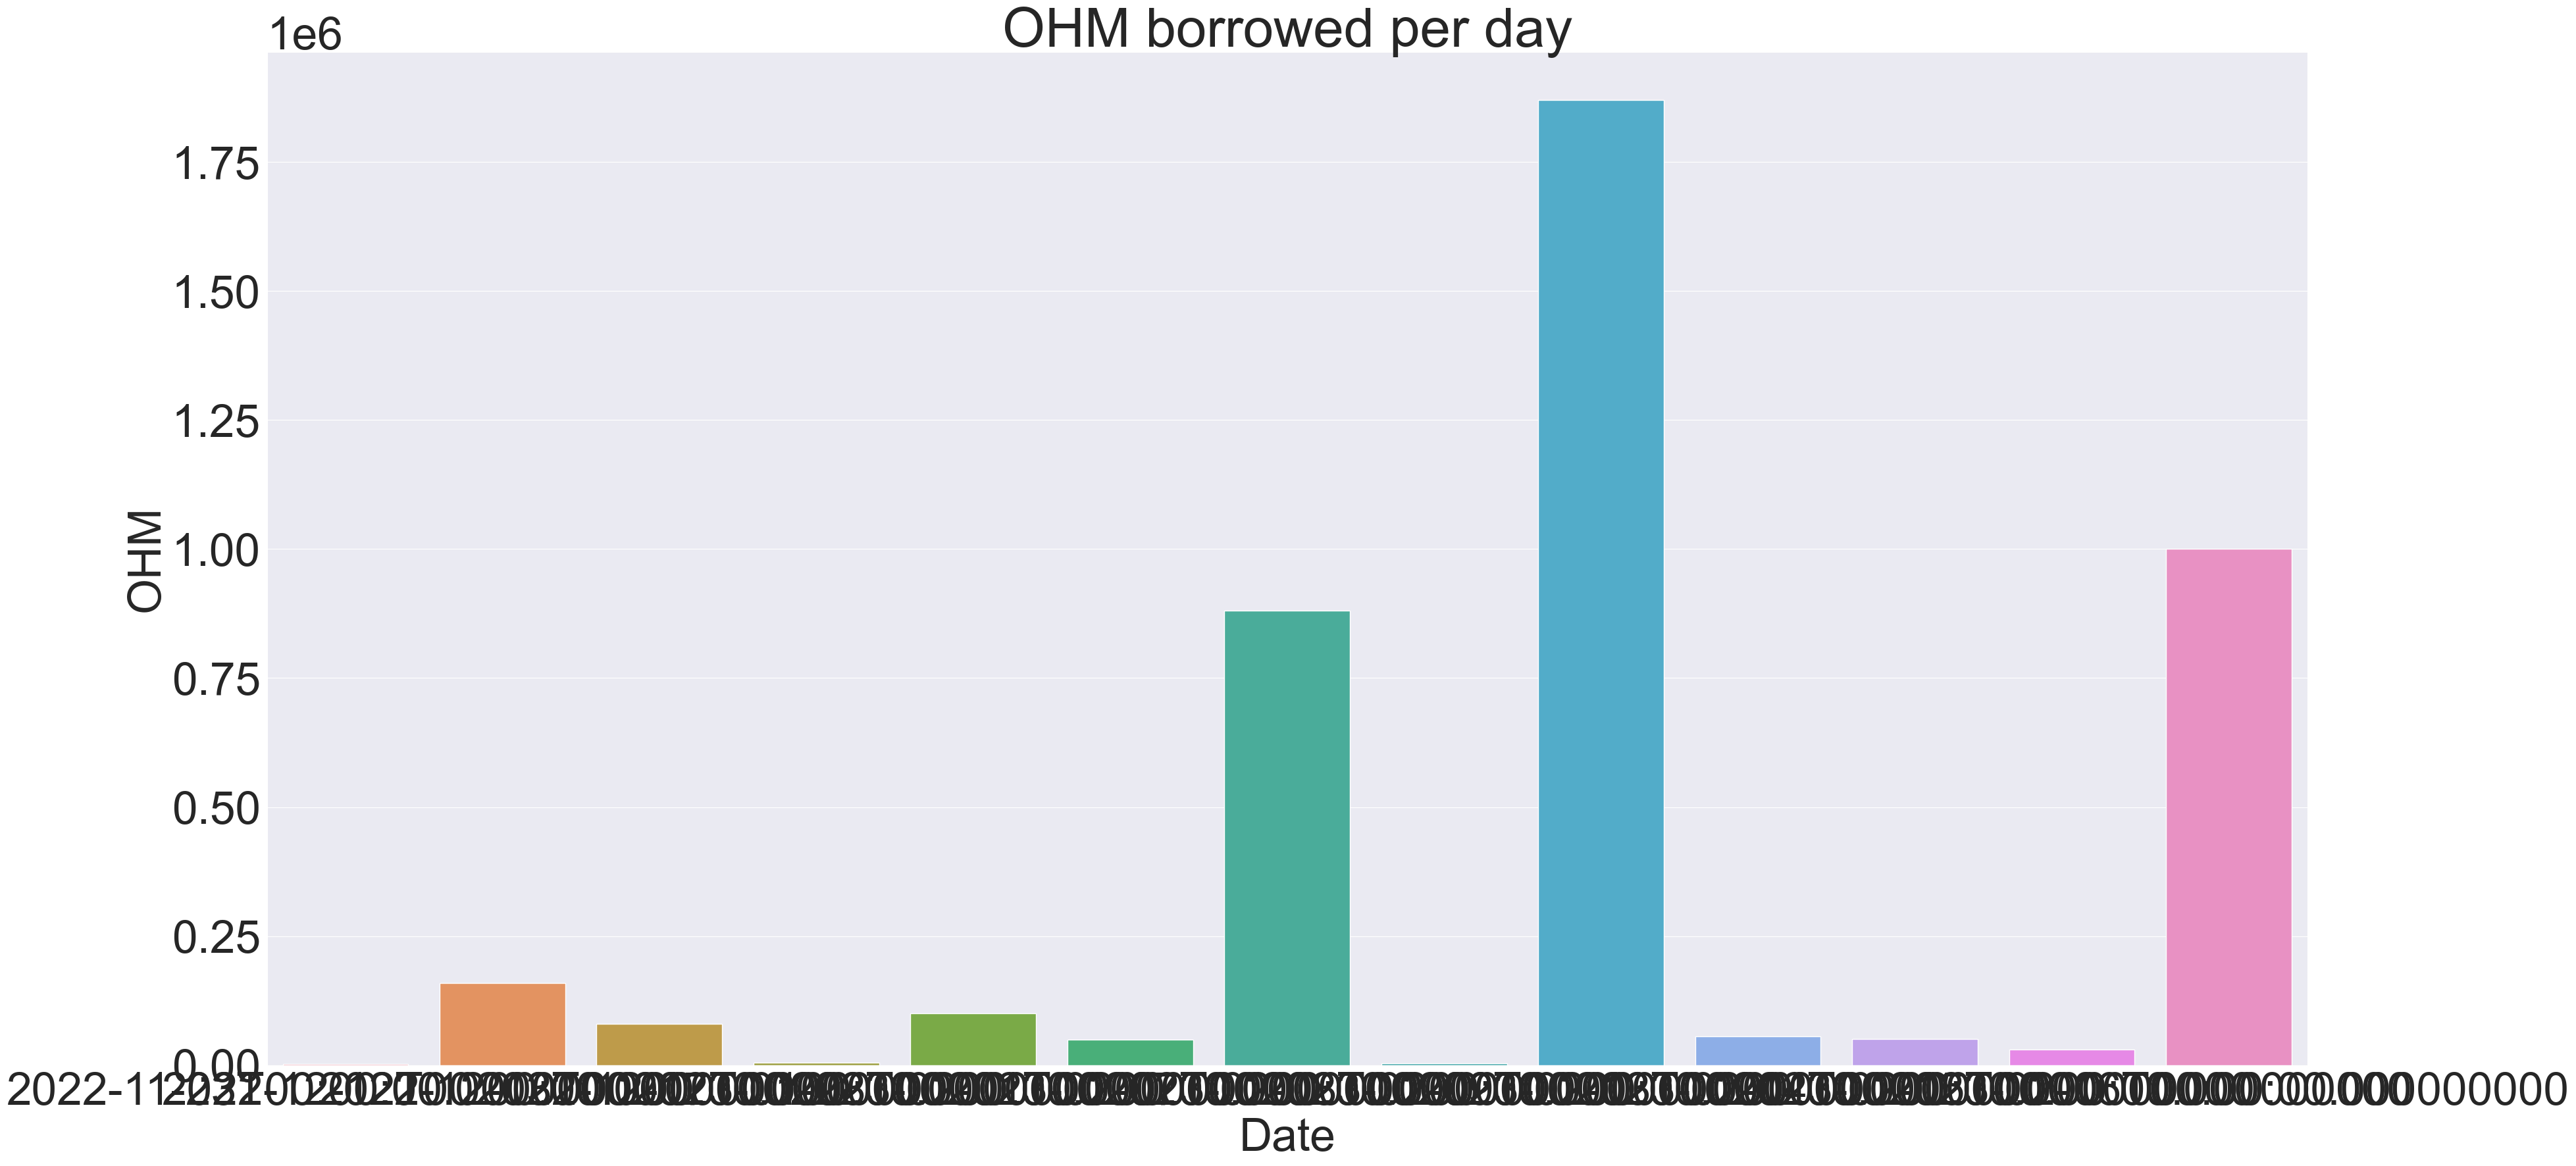

In [32]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = siloBorrowEventsDbTimedClean.groupby("calDate")["transactionReadableAmount"].agg("sum").reset_index()
plot_title = 'OHM borrowed per day'
chart=sns.barplot(data=value_locked,y="transactionReadableAmount",x="calDate").set(title = plot_title, xlabel = 'Date', ylabel = 'OHM', )
print(chart)

********************************************************************
********************************************************************
VESTA BORROWS - Their API is poo RN

In [33]:
#https://api.thegraph.com/subgraphs/name/corerouter/vesta-finance
vesta = sg.load_api('https://api.thegraph.com/subgraphs/name/shinitakunai/vestafinance-v1_2')

In [34]:
oldVestaBorrowsDb = pd.DataFrame()
siloFileName = file+'/vesta_borrow_events.csv'
try:
    oldVestaBorrowsDb = pd.read_csv (siloFileName)
except:
    oldVestaBorrowsDb = pd.DataFrame()
oldVestaBorrowsDb.head(100)

""


In [35]:
maxVestaBorrowTimestamp = 0
try:
    maxVestaTroveChangeId = (max(0,oldVestaBorrowsDb['troveChanges_id'].max()))
    maxVestaTroveChangeId = int(maxVestaTroveChangeId)
    vestaBorrows = vesta.Query.troveChanges(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                ,'debtChange_lt':0
                ,'id_gte': maxVestaTroveChangeId
         }
        )
    vestaBorrowslist = sg.query_df([
            vestaBorrows.id
            ,vestaBorrows.transaction.id
            ,vestaBorrows.transaction.blockNumber
            ,vestaBorrows.debtChange
            ,vestaBorrows.transaction.timestamp
            ,vestaBorrows.trove.owner.id
            ,vestaBorrows.trove.asset.id
            ,vestaBorrows.trove.asset.name
        ])
except:
    maxVestaTroveChangeId = 0
    vestaBorrows = vesta.Query.troveChanges(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                ,'debtChange_lt':0
               #,'id_gte': maxVestaTroveChangeId
         }
    )
    vestaBorrowslist = sg.query_df([
            vestaBorrows.id
            ,vestaBorrows.transaction.id
            ,vestaBorrows.transaction.blockNumber
            ,vestaBorrows.debtChange
            ,vestaBorrows.transaction.timestamp
            ,vestaBorrows.trove.owner.id
            ,vestaBorrows.trove.asset.id
            ,vestaBorrows.trove.asset.name
        ])

vestaBorrowslist.head(10)

,troveChanges_id,troveChanges_transaction_id,troveChanges_transaction_blockNumber,troveChanges_debtChange,troveChanges_transaction_timestamp,troveChanges_trove_owner_id,troveChanges_trove_asset_id,troveChanges_trove_asset_name
0,99981,0xf935941fd9f2518fa2a5f5f8d29dfa38c92fccb25b75...,34713629,-0.100000,1667397544,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
1,99820,0x467b6aa4a3f3d45e9316a143c45bf91c83ed1f662a4b...,34701032,-0.010000,1667393421,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
2,9972,0xfd781bb00f9e6d9599ce7aebda95979bfb902d3d73d2...,11845437,-2848.848834,1652313237,0x0c20e9958e4eb2d9c112d1469e17ab6c830cde09,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
3,99669,0xe104d6896bf784009bd9aa410f077f9c0a25154ab628...,34691865,-0.100000,1667390188,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
4,9962,0x2fde74916c909648c83e2725fecdc902181371a58c1f...,11842359,-700.000000,1652309981,0xe9f6711b7c92581856e0419399bc4fb9c36ec7e3,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
5,9961,0x1ebcd76a95f023492880bf7f7fbf3183e2197dd266a2...,11841593,-156.000000,1652309386,0x20fd6151bb6c78c6b5c89859bd5076dd852cc461,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
6,99531,0xc4558983947cedeace28d691cf9a70d871256ccd9021...,34681251,-0.020000,1667386332,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
7,9924,0x6a478fd975875045387ad810583e8270a25530599a6d...,11835231,-4000.003949,1652304099,0x6688b44ff874e246c441397d60fc169d4972a1ab,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
8,99043,0x24f693681f80f12946d463995c424c41f37a01dbd227...,34647273,-31300.004280,1667374762,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
9,9896,0xdf29dc3054d53c0c8681ba1e5a9ab72d0dafbcf77de4...,11831764,-222.000000,1652301736,0x7ff15d6cf1a7bf0efa7435543cf086835fc80d53,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM


vestaBorrows = vesta.Query.troveChanges(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                ,'debtChange_lt':0
                ,'id_gte': maxVestaTroveChangeId
         }
    )
vestaBorrowslist = sg.query_df([
        vestaBorrows.id
        ,vestaBorrows.transaction.id
        ,vestaBorrows.transaction.blockNumber
        ,vestaBorrows.debtChange
        ,vestaBorrows.transaction.timestamp
        ,vestaBorrows.trove.owner.id
        ,vestaBorrows.trove.asset.id
        ,vestaBorrows.trove.asset.name
    ])

vestaBorrowslist.head(10)

In [36]:
##this captures the list of people who vestaBorrowed XAI against gOHM
vestaBorrowTicker = 0
vestaBorrowslist = pd.DataFrame()
vestaBorrowsDb = pd.DataFrame()
vestaBorrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaBorrowTicker)*(1000)
    try:
        maxVestaTroveChangeId = (max(0,oldVestaBorrowsDb['troveChanges_id'].max()))
        maxVestaTroveChangeId = int(maxVestaTroveChangeId)
        vestaBorrows = vesta.Query.troveChanges(
            orderBy='id',
            orderDirection='desc',
            first=1000,
            skip = skipValue,
            where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                    ,'debtChange_gt':0
                    ,'id_gte': maxVestaTroveChangeId
             }
            )
        vestaBorrowslist = sg.query_df([
                vestaBorrows.id
                ,vestaBorrows.transaction.id
                ,vestaBorrows.transaction.blockNumber
                ,vestaBorrows.debtChange
                ,vestaBorrows.transaction.timestamp
                ,vestaBorrows.trove.owner.id
                ,vestaBorrows.trove.asset.id
                ,vestaBorrows.trove.asset.name
            ])
    except:
        maxVestaTroveChangeId = 0
        vestaBorrows = vesta.Query.troveChanges(
            orderBy='id',
            orderDirection='desc',
            first=1000,
            skip = skipValue,
            where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                    ,'debtChange_gt':0
                   #,'id_gte': maxVestaTroveChangeId
             }
        )
        vestaBorrowslist = sg.query_df([
                vestaBorrows.id
                ,vestaBorrows.transaction.id
                ,vestaBorrows.transaction.blockNumber
                ,vestaBorrows.debtChange
                ,vestaBorrows.transaction.timestamp
                ,vestaBorrows.trove.owner.id
                ,vestaBorrows.trove.asset.id
                ,vestaBorrows.trove.asset.name
            ])

    #vestaBorrowslist.sort_values(by=['vestaBorrows_timestamp'])

    vestaBorrowsDb=pd.concat([vestaBorrowsDb, vestaBorrowslist])
    recordTimestamp1 = vestaBorrowsDb.iat[vestaBorrowTicker,4]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaBorrowsDbLength = len(vestaBorrowsDb)
    vestaBorrowListLength = len(vestaBorrowslist)
    recordID = vestaBorrowsDb.iat[vestaBorrowTicker,0]
    vestaBorrow = vestaBorrowsDb.iat[vestaBorrowTicker,1]
    print("iterations: ", vestaBorrowTicker, "Lines skipped: ",skipValue, "records collected: ", vestaBorrowListLength, " - latest recordID: ",vestaBorrow, " ", recordID , " - vestaBorrows DB length: ", vestaBorrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaBorrowTicker, "records collected: ", vestaBorrowListLength, " - userdb length: ", vestaBorrowsDbLength)
    vestaBorrowTicker = vestaBorrowTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaBorrowListLength<1000: exit =True

#vestaBorrowsDbTimed.columns = vestaBorrowsDbTimed.columns.str.replace("borrows", "transaction")
vestaBorrowsDb['event']='borrow'
print("Done. Total Records collected: ", vestaBorrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0x21da8f0687a20a391e7e08c8af41efd288af11da388165d1fe8423ff8468ed59   9966  - vestaBorrows DB length:  1000  - latest record from:  2022-05-11 16:41:54 282 days ago
Done. Total Records collected:  1000


In [37]:
vestaBorrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(troveChanges_transaction_timestamp::int) dateTime "
               "From vestaBorrowsDb "
                               "order by troveChanges_transaction_timestamp desc"
               ).df()

vestaBorrowsDbTimed.head(1000)

,troveChanges_id,troveChanges_transaction_id,troveChanges_transaction_blockNumber,troveChanges_debtChange,troveChanges_transaction_timestamp,troveChanges_trove_owner_id,troveChanges_trove_asset_id,troveChanges_trove_asset_name,event,dateTime
0,207284,0xe4b82c5ad6568b3fba9c61529ba436212cb63135d89d...,61633205,15000.054430,1676599370,0x0fd84d7cb911728737556684050782b298f70f0f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-17 02:02:50
1,207280,0x35f475613ab25f47dac0a9fda37a240c25e4dc942ad7...,61624082,35000.034097,1676596693,0x0fd84d7cb911728737556684050782b298f70f0f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-17 01:18:13
2,207248,0xb7f08ff6e6e98a72accebd20d4276a05b0b21b721b2c...,61559600,118625.963501,1676577954,0x0fd84d7cb911728737556684050782b298f70f0f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-16 20:05:54
3,207220,0x01346ac1caa688e316ece2728bba124fde264594ef1f...,61525970,100.280000,1676568608,0x9abcd812bffc1ef2e81a2dde75b5ed8809289d9d,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-16 17:30:08
4,207169,0xc45acca1801af69bde73afbf49eca4e1926202056548...,61432572,0.000428,1676544447,0xc9e166f2737e004e93800dcef0d608b014df07f6,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-16 10:47:27
...,...,...,...,...,...,...,...,...,...,...
995,321,0xe7a2f919a8b75cdfda3826f235fb6fb09d7fe3a285d2...,5697588,2231.175000,1644385430,0x1cb4831b6df1d9cb07279b93a0e101db9b2295d0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:43:50
996,313,0x8a69f94169d23f37811def09cee4008e7305b538a748...,5697498,12180.000000,1644385318,0xf5b4635f3858a2bc80a17bd4450e05a35ad99a72,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:41:58
997,312,0x3cf08c9c4d3cf6c6a5bfd9bc707237a199ac0eb0559c...,5697463,333.750000,1644385225,0x87209dc4b76b14b67bc5e5e5c0737e7d002a219c,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:40:25
998,305,0x54c221378376ddc4b488cf03648bbc0a83ad6f51ca9f...,5697391,1567.755688,1644385147,0x56c6e3385acc23826ef764066fa5a5f422c78e14,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:39:07


In [38]:
vestaBorrowsDbTimed = pd.concat([oldVestaBorrowsDb,vestaBorrowsDbTimed]).drop_duplicates().reset_index(drop=True)
vestaBorrowsDbTimed.drop_duplicates()
vestaBorrowsDbTimed = db.query("select "
               "    * "
               "From vestaBorrowsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10 "
                     # "order by borrows_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaBorrowsDbTimed.head(100)

,troveChanges_id,troveChanges_transaction_id,troveChanges_transaction_blockNumber,troveChanges_debtChange,troveChanges_transaction_timestamp,troveChanges_trove_owner_id,troveChanges_trove_asset_id,troveChanges_trove_asset_name,event,dateTime
0,207284,0xe4b82c5ad6568b3fba9c61529ba436212cb63135d89d...,61633205,15000.054430,1676599370,0x0fd84d7cb911728737556684050782b298f70f0f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-17 02:02:50
1,207280,0x35f475613ab25f47dac0a9fda37a240c25e4dc942ad7...,61624082,35000.034097,1676596693,0x0fd84d7cb911728737556684050782b298f70f0f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-17 01:18:13
2,207248,0xb7f08ff6e6e98a72accebd20d4276a05b0b21b721b2c...,61559600,118625.963501,1676577954,0x0fd84d7cb911728737556684050782b298f70f0f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-16 20:05:54
3,207220,0x01346ac1caa688e316ece2728bba124fde264594ef1f...,61525970,100.280000,1676568608,0x9abcd812bffc1ef2e81a2dde75b5ed8809289d9d,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-16 17:30:08
4,207169,0xc45acca1801af69bde73afbf49eca4e1926202056548...,61432572,0.000428,1676544447,0xc9e166f2737e004e93800dcef0d608b014df07f6,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-16 10:47:27
...,...,...,...,...,...,...,...,...,...,...
95,178118,0xef2484a406a86191d25671f4fbd001ccd9621a1cd765...,50774953,150.000017,1672830256,0x9abcd812bffc1ef2e81a2dde75b5ed8809289d9d,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-01-04 11:04:16
96,177591,0x25ad89683e20f8ebdb2c39fe58d44e4128a2b761abbb...,50737004,1274.995509,1672818528,0xee85ae5daab560731243403f56c51654def8bc6e,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-01-04 07:48:48
97,166441,0x0510f38187287337149c55f0df24e23784af8adc1694...,50180608,535.490000,1672585868,0xc15105959da75e1294f9c2146ba014b4e84cd302,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-01-01 15:11:08
98,166216,0xf4e262bc02fbe53cdc2dae0396cf98e6132f02f730c1...,49877839,305000.000000,1672432598,0x4576c98ab60de9372d0280348ac7c1e9d32bff05,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-12-30 20:36:38


In [39]:
path =file+'/vesta_borrow_events.csv'
vestaBorrowsDbTimed.to_csv(path, index = False)

path =file+'/vesta_borrow_events_piped.csv'
vestaBorrowsDbTimed.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(vestaBorrowsDbTimed),' records')

/Users/ianbrillembourg/Dropbox/Documents/Edgecaser LLC/Projects/Olympus/Econohmetrics/gohmAsStablecoinCollateral/data/vesta_borrow_events_piped.csv file saved, 1000  records


************************************************************
FINE.... FRAX TOO

This subgraph is completely different, so we're going to  have to crunch in order to merge all these tables into coherent reports

In [40]:
frax = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/GELTrjPJYEzxyp6Y2CtEaYpGHcJNrJA6i5Ci4KfJSEsf')
#frax = sg.load_api('https://api.thegraph.com/subgraphs/name/frax-finance-data/fraxlend-subgraph---mainnet')


In [41]:
oldFraxBorrows = pd.DataFrame()
fraxFileName = file+'/frax_borrows.csv'
try:
    oldFraxBorrows = pd.read_csv (fraxFileName)
except:
    oldFraxBorrows = pd.DataFrame()
oldFraxBorrows.head(100)

""


In [42]:
maxBorrowFraxTimestamp = 0
try:
    maxBorrowFraxTimestamp = (max(1,oldFraxBorrows['actions_timestamp'].max()))-5
except:
        maxBorrowFraxTimestamp = 0
maxBorrowFraxTimestamp = int(maxBorrowFraxTimestamp)
maxBorrowFraxTimestamp

0

In [44]:
actionListLength=0
actionTicker = 0
fraxUsersDb = pd.DataFrame()
actionsDb = pd.DataFrame()
actionListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    #listLength=0
    skipValue = (actionTicker)*(1000)
    actionsQuery = frax.Query.actions(
         orderBy='timestamp'
        ,orderDirection='desc'
        ,first=1000
        ,skipValue = skipValue
        #,where = [frax.Query.actions.token.id == '0x66bf36dba79d4606039f04b32946a260bcd3ff52']
        ,where={ 'pair': '0x66bf36dba79d4606039f04b32946a260bcd3ff52'
                 ,'timestamp_gte': maxBorrowFraxTimestamp
                 }
        #,where = {'positions.pairid':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}
    #{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

    )
    actions= sg.query_df([
        actionsQuery.id
        ,actionsQuery.type
        ,actionsQuery.amount
        ,actionsQuery.timestamp
        ,actionsQuery.block
        ,actionsQuery.token.name
        ,actionsQuery.root.address
        ,actionsQuery.pair.asset.symbol
        ,actionsQuery.pair.asset.decimals
        ,actionsQuery.pair.collateral.symbol
        ,actionsQuery.pair.collateral.decimals
        ]
    )

    actions.sort_values(by=['actions_timestamp'])

    actionsDb=pd.concat([actionsDb, actions])
    recordTimestamp1 = actionsDb.iat[actionTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    actionsDbLength = len(actionsDb)
    actionListLength = len(actions)
    recordID = actionsDb.iat[actionTicker,0]
    action = actionsDb.iat[actionTicker,1]
    print("iterations: ", actionTicker, "Lines skipped: ",skipValue, "records collected: ", actionListLength, " - latest recordID: ",action, " ", recordID , " - actions DB length: ", actionsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", actionTicker, "records collected: ", actionListLength, " - userdb length: ", actionsDbLength)
    if daysAgo>daysLimit: exit =True
    if actionsDbLength<1000: exit =True
    actionTicker = actionTicker+1
print("Done. Total Records collected: ", actionsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  removeAsset   0xab2afc62785cd5e9e2dd310cd1b84ca742f33cc6a979cf43b1a5f3601e5b96c0  - actions DB length:  1000  - latest record from:  2023-02-17 04:10:59 0 days ago
iterations:  1 Lines skipped:  1000 records collected:  1000  - latest recordID:  borrowAsset   0x8ee4b2c2631549768e73d5b47b7755715c06063dba9dfd8be35f5b2ab81cf4c6  - actions DB length:  2000  - latest record from:  2023-02-17 03:44:59 0 days ago
iterations:  2 Lines skipped:  2000 records collected:  1000  - latest recordID:  borrowAsset   0x41c98727ed46b57cee2bdc6d552d733cbe9a43a02fef9f5252f1f0e95bac5dd0  - actions DB length:  3000  - latest record from:  2023-02-16 16:48:47 1 days ago
iterations:  3 Lines skipped:  3000 records collected:  1000  - latest recordID:  repayAsset   0xc84158cfb0de12eb6da22f0e9f373de223e81cbb2901507cf3a5375e461699d5  - actions DB length:  4000  - latest record from:  2023-02-16 15:49:11 1 days ago
iterations:  4 Lines

In [46]:
    fraxActionsDbTimed = db.query("select "
                   "    * "
                        " ,to_timestamp(actions_timestamp) dateTime "
                    ",(actions_amount::hugeint*1e-18) readableAmount "
                   "From actionsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
fraxActionsDbTimed.head(10)

,actions_id,actions_type,actions_amount,actions_timestamp,actions_block,actions_token_name,actions_root_address,actions_pair_asset_symbol,actions_pair_asset_decimals,actions_pair_collateral_symbol,actions_pair_collateral_decimals,dateTime,readableAmount
0,0xab2afc62785cd5e9e2dd310cd1b84ca742f33cc6a979...,removeAsset,4.009793e+22,1676635859,16648345,Frax,0x67d031c3473e5a818923c42640d5871c82a5bb4a,FRAX,18,gOHM,18,2023-02-17 12:10:59,40097.932546
1,0x8ee4b2c2631549768e73d5b47b7755715c06063dba9d...,borrowAsset,1.000000e+22,1676634299,16648217,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-17 11:44:59,10000.000000
2,0x41c98727ed46b57cee2bdc6d552d733cbe9a43a02fef...,borrowAsset,2.000000e+22,1676594927,16644974,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-17 00:48:47,20000.000000
3,0xc84158cfb0de12eb6da22f0e9f373de223e81cbb2901...,repayAsset,2.251201e+22,1676591351,16644678,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-16 23:49:11,22512.007177
4,0x0dcc234aa537f7245de13296bd9f19b031cb0d60d942...,borrowAsset,0.000000e+00,1676590103,16644575,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-16 23:28:23,0.000000
5,0x0dcc234aa537f7245de13296bd9f19b031cb0d60d942...,addCollateral,9.750000e+17,1676590103,16644575,Governance OHM,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-16 23:28:23,0.975000
6,0xa43b5cafe8fa36b170da2572f2d81f10005edec53721...,removeCollateral,2.000000e+18,1676589371,16644514,Governance OHM,0x783f3cad39b6528e192722527429bbbdaad01648,FRAX,18,gOHM,18,2023-02-16 23:16:11,2.000000
7,0xcfc1e4017009147238d042380cebf72824c49cf03523...,repayAsset,2.536800e+22,1676584019,16644070,Frax,0xf10918fc1725a65960db2b906b4868a0fdbb6870,FRAX,18,gOHM,18,2023-02-16 21:46:59,25368.003616
8,0x26cce8d6cb5173fd5d3feac628ecbba1c1de437b7bdb...,removeCollateral,9.000000e+18,1676582963,16643982,Governance OHM,0xf10918fc1725a65960db2b906b4868a0fdbb6870,FRAX,18,gOHM,18,2023-02-16 21:29:23,9.000000
9,0x795f1995f3ae71df4538b386f0eafd55e3da0c016f1e...,borrowAsset,0.000000e+00,1676582339,16643930,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-16 21:18:59,0.000000


In [53]:
fraxActionsDbTimed = pd.concat([oldFraxBorrows,fraxActionsDbTimed]).drop_duplicates().reset_index(drop=True)
fraxActionsDbTimed.sort_values(['actions_id','actions_type','actions_amount','actions_timestamp','actions_block','actions_token_name','actions_root_address','dateTime'])
fraxActionsDbTimed.drop_duplicates(keep='first' )
fraxActionsDbTimed.head(100)

,actions_id,actions_type,actions_amount,actions_timestamp,actions_block,actions_token_name,actions_root_address,actions_pair_asset_symbol,actions_pair_asset_decimals,actions_pair_collateral_symbol,actions_pair_collateral_decimals,dateTime,readableAmount
0,0xab2afc62785cd5e9e2dd310cd1b84ca742f33cc6a979...,removeAsset,4.009793e+22,1676635859,16648345,Frax,0x67d031c3473e5a818923c42640d5871c82a5bb4a,FRAX,18,gOHM,18,2023-02-17 12:10:59,40097.932546
1,0x8ee4b2c2631549768e73d5b47b7755715c06063dba9d...,borrowAsset,1.000000e+22,1676634299,16648217,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-17 11:44:59,10000.000000
2,0x41c98727ed46b57cee2bdc6d552d733cbe9a43a02fef...,borrowAsset,2.000000e+22,1676594927,16644974,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-17 00:48:47,20000.000000
3,0xc84158cfb0de12eb6da22f0e9f373de223e81cbb2901...,repayAsset,2.251201e+22,1676591351,16644678,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-16 23:49:11,22512.007177
4,0x0dcc234aa537f7245de13296bd9f19b031cb0d60d942...,borrowAsset,0.000000e+00,1676590103,16644575,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-16 23:28:23,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x24436c0d5c6419ffac45c32d4115128f4075a9ace872...,addCollateral,1.859911e+18,1675886867,16586318,Governance OHM,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-08 20:07:47,1.859911
96,0x5520cee4dfed2595a6f9d0de5f3b8f26b874112fa11e...,borrowAsset,5.000000e+21,1675886663,16586301,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-08 20:04:23,5000.000000
97,0x4e156dda6a27c39160c859b3b5327334d50c02b8d09f...,borrowAsset,0.000000e+00,1675886339,16586274,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-08 19:58:59,0.000000
98,0x4e156dda6a27c39160c859b3b5327334d50c02b8d09f...,addCollateral,3.728740e+18,1675886339,16586274,Governance OHM,0xc0e0de939f26e71683452467942aff455ca153e3,FRAX,18,gOHM,18,2023-02-08 19:58:59,3.728740


In [67]:
fraxActionsDbTimedLength = len(fraxActionsDbTimed)
path =file+'/frax_borrows.csv'
fraxActionsDbTimed.to_csv(path, index = False)

path =file+'/frax_borrows_piped.csv'
fraxActionsDbTimed.to_csv(path, index = False, sep='|')

print(path, 'file saved,', fraxActionsDbTimedLength,' records at', (dt.datetime.now()) )

/Users/ianbrillembourg/Dropbox/Documents/Edgecaser LLC/Projects/Olympus/Econohmetrics/gohmAsStablecoinCollateral/data/frax_borrows_piped.csv file saved, 1000  records at 2023-02-17 10:48:51.364381


In [68]:
fraxBorrowsDb = db.query("select distinct"
                   "    actions_root_address "
                         ", dateTime "
                         ", readableAmount "
                         ", actions_token_name "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'borrowAsset'"
                         "order by 3 desc "
                   ).df()
fraxBorrowsDb.head(10)

,actions_root_address,dateTime,readableAmount,actions_token_name
0,0x03da5c3b75503a1dda58e2bd23d4726b5ee8dd26,2022-12-28 02:04:23,560968.505801,Frax
1,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-08 17:58:59,400000.000000,Frax
2,0xbf23c4820def2ed7cab808bec348f7072035a289,2022-12-16 19:03:47,376035.401417,Frax
3,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,2023-01-18 14:29:59,350000.000000,Frax
4,0x2a363fccde360dea7b0df06ed5416f925ed62ef7,2022-12-23 21:38:35,350000.000000,Frax
5,0xb0399dac8f4d4100b49b2a7b3873481114229d18,2023-01-30 18:09:59,305000.000000,Frax
6,0x1effd55a8646f7dc67c7578c20ce575cefeb1120,2023-01-23 15:28:59,300000.000000,Frax
7,0x85b44a83bca937e844bdc290284ef6b11bc015ba,2022-12-04 16:30:11,214099.334643,Frax
8,0xe27ce7decbe14d1243efe2c927d3c090963aa1d3,2022-12-26 17:15:59,200000.000000,Frax
9,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-09 18:31:11,200000.000000,Frax


In [69]:
fraxBorrowsDb.drop_duplicates
fraxBorrowsDbLength = len(fraxBorrowsDb)
path =file+'/frax_borrows.csv'
fraxBorrowsDb.to_csv(path, index = False)

path =file+'/frax_borrows_piped.csv'
fraxBorrowsDb.to_csv(path, index = False, sep='|')
print('file saved at', (dt.datetime.now()))

file saved at 2023-02-17 10:48:53.958551


**********************************************************
LET'S PLAY AND CRUNCH DATA - BORROWS


In [80]:
fraxBorrowedDaily = db.query("select "
                   "    date_trunc('day', cast(dateTime as timestamp)) calDay "
                         ", sum(readableAmount) readableAmountBorrowed"
                         ", count(distinct actions_root_address) borrowers "
                       "From fraxBorrowsDb "
                        "Group by 1 "
                        "order by 1 "
                   ).df()


fraxBorrowedDaily['protocol'] = 'Frax'
fraxBorrowedDaily.head(100)

,calDay,readableAmountBorrowed,borrowers,protocol
0,2022-12-04,254099.334643,4,Frax
1,2022-12-05,508933.348518,5,Frax
2,2022-12-06,5000.000000,1,Frax
3,2022-12-07,206250.000000,3,Frax
4,2022-12-08,531726.823715,7,Frax
...,...,...,...,...
68,2023-02-13,54000.000000,2,Frax
69,2023-02-14,75000.000000,3,Frax
70,2023-02-15,20420.000000,2,Frax
71,2023-02-16,20000.000000,1,Frax


In [74]:
siloBorrowed = db.query(
                        "select distinct "
                            "date_trunc('day',cast(dateTime as timestamp)) calDay "
                            ",transactionReadableAmount::hugeint readableAmountBorrowed "
                        "   ,transaction_account_id "
                       "From siloBorrowEventsDbTimedClean "
                   ).df()

siloBorrowed.head(10)

,calDay,readableAmountBorrowed,transaction_account_id
0,2023-02-09,1860000.0,0xb0399dac8f4d4100b49b2a7b3873481114229d18
1,2023-02-16,1000000.0,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb
2,2023-02-13,264.0,0x46535cbc3fa574c32ea392d4f89c518290597072
3,2023-02-07,300000.0,0x0493bcca897a2248ae3cd4c66aea90dbfc7e13c6
4,2023-02-07,250000.0,0x36125234dd6c7d0a01dcadc67e79e061d405098e
5,2023-02-07,200000.0,0x96035b45bc0d22f0ed11283a91145fb001c48370
6,2022-12-12,119000.0,0x1ba67f30e25fc43863b50047d7fd4bd63b9c59ec
7,2023-01-28,100000.0,0x42daeb9ca091e3933c8ee93c029701b926b1f336
8,2022-12-13,80000.0,0x339fd7c17ce670e7821f2f2ee94ddd49771483da
9,2023-02-07,70000.0,0xb86cd2efc1f461beee8deec2c3f053ccb2781ef9


In [76]:
siloBorrowedDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(readableAmountBorrowed::hugeint) readableAmountBorrowed "
                        "   ,count(distinct transaction_account_id) borrowers "
                       "From siloBorrowedUSD "
                        "Group by 1 "
                   ).df()
siloBorrowedDaily['protocol'] = 'Silo'
siloBorrowedDaily.head(100)

,calDay,readableAmountBorrowed,borrowers,protocol
0,2023-02-09,1870000.0,2,Silo
1,2023-02-16,1000006.0,2,Silo
2,2023-02-13,55739.0,2,Silo
3,2023-02-07,880300.0,5,Silo
4,2022-12-12,159000.0,2,Silo
5,2023-01-28,100000.0,1,Silo
6,2022-12-13,80000.0,1,Silo
7,2023-02-01,50000.0,1,Silo
8,2023-02-14,50019.0,3,Silo
9,2023-02-15,30000.0,1,Silo


In [ ]:
vestaBorrowedUSD = db.query(
                        "select distinct "
                            "date_trunc('day',cast(dateTime as timestamp)) calDay "
                            ",troveChanges_debtChange::hugeint troveChanges_debtChange "
                        "   ,troveChanges_trove_owner_id  "
                       "From vestaBorrowsDbTimed "
                   ).df()

In [ ]:
vestaBorrowedUSDDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(troveChanges_debtChange) amountUsdBorrowed "
                        "   ,count(distinct troveChanges_trove_owner_id) borrowers "
                       "From vestaBorrowedUSD "
                        "Group by 1 "
                   ).df()
vestaBorrowedUSDDaily['protocol'] = 'Vesta'
vestaBorrowedUSDDaily.head(100)

In [82]:
#Don't judge if I use pandas for some things and SQL for others. I'm a noob :P
dailyUsdBorrowdDb =  pd.concat([siloBorrowedDaily,fraxBorrowedDaily])#vestaBorrowedUSDDaily, for when it is not poopy
dailyUsdBorrowdDb.head(400)

,calDay,readableAmountBorrowed,borrowers,protocol
0,2023-02-09,1870000.0,2,Silo
1,2023-02-16,1000006.0,2,Silo
2,2023-02-13,55739.0,2,Silo
3,2023-02-07,880300.0,5,Silo
4,2022-12-12,159000.0,2,Silo
...,...,...,...,...
68,2023-02-13,54000.0,2,Frax
69,2023-02-14,75000.0,3,Frax
70,2023-02-15,20420.0,2,Frax
71,2023-02-16,20000.0,1,Frax


In [ ]:
dailyUsdBorrowdDbLength = len(dailyUsdBorrowdDb)
path =file+'/dailyUsdBorrowed.csv'
dailyUsdBorrowdDb.to_csv(path, index = False)

path =file+'/dailyUsdBorrowed_piped.csv'
dailyUsdBorrowdDb.to_csv(path, index = False, sep='|')
print('file saved')

In [ ]:
dailyUsdBorrowdDbLength

In [ ]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = dailyUsdBorrowdDb.groupby("calDay")["amountUsdBorrowed"].agg("sum").reset_index()
plot_title = 'Borrowed per day'
chart=sns.barplot(data=value_locked,y="amountUsdBorrowed",x="calDay").set(title = plot_title, xlabel = 'protocol', ylabel = 'USD', )
print(chart)

In [ ]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = dailyUsdBorrowdDb.groupby("protocol")["amountUsdBorrowed"].agg("sum").reset_index()
plot_title = 'Borrowed per protocol'
chart=sns.barplot(data=value_locked,y="amountUsdBorrowed",x="protocol").set(title = plot_title, xlabel = 'protocol', ylabel = 'USD', )
print(chart)